In [1]:
!pip install imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn packages (for pre-processing, model-building, evaluators, cross-validators, etc.)
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder

# Imblearn packages (for over_sampling and imblearn pipelines)
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline  ## Using packages from imblearn.pipeline for making pipelines

## xgboost packages
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [3]:
df_cct = pd.read_parquet("/home/onyxia/work/df_cct_stand2.parquet")

### Correlation map

<Axes: >

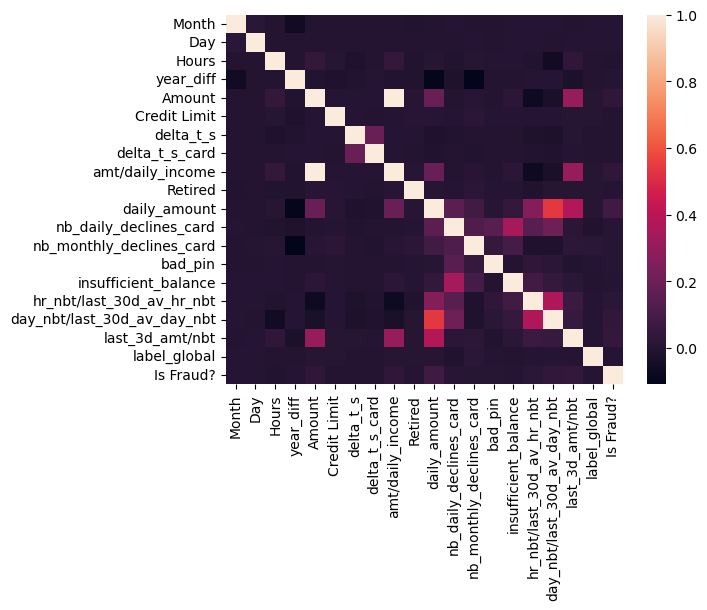

In [3]:
sns.heatmap(df_cct[['Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?']].corr())

In [4]:
df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?'],
      dtype='object')

### Preprocessing (code to create standarized (by User) dataset) - DO NOT RUN

In [19]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = df_cct.loc[:,~df_cct.columns.isin(["User","Card","label_global","Retired", "bad_pin", "insufficient_balance","Is Fraud?"])].select_dtypes(include=numerics).columns.to_list()
cat = df_cct.select_dtypes(include=['object']).columns.to_list()


In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df = pd.DataFrame()
for i in range(2000):
    user_i = df_cct[df_cct["User"] == i]
    user_i[num] = scaler.fit_transform(user_i[num])
    df = pd.concat([df,user_i], axis=0)


In [51]:
#df.to_parquet("/home/onyxia/work/df_cct_stand2.parquet")

### Encode categorical variables

In [4]:
# Pour "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [5]:
# Pour "Card Brand":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Brand"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [6]:
# Pour "Card Type"":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Type"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [6]:
df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction', 'Amex', 'Discover', 'Mastercard', 'Visa', 'Credit',
       'Debit', 'Debit (Prepaid)'],
      dtype='object')

### Create train/val/test datasets

In [7]:
# selecting features
# dropped card, nb_weekly_declines, day_of_week, nb_daily_declines, credit, debit, amex,  discover,
# mastercard, visa
features = ['Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)',
        "label_global","Is Fraud?"]
df_selec = df_cct[features] # 21 features
X = df_selec[['Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)']]
y = df_selec["Is Fraud?"]

In [8]:
## Splitting the data into train and test data  (70:30)

## Create a STRATIFIED train-test (Hence, passing the argument 'stratify= y')
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, shuffle = True, random_state = 0, stratify = y)


In [9]:
## Checking class distribution in stratified train-test split
from collections import Counter

print("In y dataset:", Counter(y))
print("\nIn y_train set:", Counter(y_train))
print("\nIn y_test set:", Counter(y_rem))

In y dataset: Counter({0: 24357143, 1: 29757})

In y_train set: Counter({0: 17050000, 1: 20830})

In y_test set: Counter({0: 7307143, 1: 8927})


In [10]:
df_rem = df_selec.loc[X_rem.index]

In [11]:
# Now since we want the valid and test size to be equal (15% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)

df_val = df_rem.sample(int(len(X_rem)*0.5), random_state = 0)
X_val = df_val.drop(["label_global", "Is Fraud?"], axis = 1)
y_val = df_val["Is Fraud?"]
df_test = df_rem.loc[~df_rem.index.isin(df_val.index.tolist())]
X_test = df_test.drop(["label_global", "Is Fraud?"], axis = 1)
y_test = df_test["Is Fraud?"]


In [12]:
# almost stratified

print("In y dataset:", Counter(y_rem))
print("\nIn y_val set:", Counter(y_val))
print("\nIn y_test set:", Counter(y_test))

In y dataset: Counter({0: 7307143, 1: 8927})

In y_val set: Counter({0: 3653663, 1: 4372})

In y_test set: Counter({0: 3653480, 1: 4555})


In [13]:
# Storing indexes for our score

i_val = df_val.index.to_list()
i_test = df_test.index.to_list()

### Model Building perso

### Model Building

In [19]:
#Create a pandas dataframe to store model results
results_df = pd.DataFrame(columns=['Data Handling Technique','Model', 'ROC_AUC_cv', 'ROC_AUC_test', 'Threshold', 'Precision','Recall','F1 score', "Our Score"])

In [20]:
# opening raw cct file
cct_init = pd.read_parquet("/home/onyxia/work/cct.parquet")
#dropping $ sign in "Amount"
cct_init["Amount"] = cct_init["Amount"].str.replace("$","")
#converting "Amount" in float
cct_init["Amount"] = cct_init["Amount"].astype(float)

#building our score
def our_score(cm, y_pred, y_val):
    tn, fp, fn, tp = cm.ravel()
    fp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y_val.values[i] == 0:
            fp_rows.append(y_val.index[i])

    fn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y_val.values[i] == 1:
            fn_rows.append(y_val.index[i])

    tp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y_val.values[i] == 1:
            tp_rows.append(y_val.index[i])

    tn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y_val.values[i] == 0:
            tn_rows.append(y_val.index[i])
    our_score = -15*(fp + tp) + cct_init.loc[tp_rows].Amount.sum() - cct_init.loc[fn_rows].Amount.sum()

    return our_score

In [21]:
def plot_confusion_matrix(cm):
    """
    This function prints and plots the confusion matrix.
    """
    classes=['Non-Fraudulent','Fraudulent']
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize= 10)
    plt.xlabel('Predicted label', fontsize=10)


def print_model_metrics(y_test,y_pred):
    print(" Model Stats Scores Summary : ")
    cp = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cp)
    plt.show()


In [22]:
## Define a function to plot ROC_AUC curve
def plot_roc_auc_curve(fpr, tpr, roc_auc):
    print(f"ROC for test dataset {round(roc_auc*100,3)}%")  
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.plot(fpr,tpr,'b',label="Test ROC_AUC="+str(round(roc_auc,3)))
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.legend(loc='lower right')
    plt.show()

## Function for printing the cross-validation results:
def best_cross_val_results(clf,data_handling_technique, model_name):
    print("\nData Handling Technique: {data_handling_technique}\nModel Name: {model_name}")
    print("\n\nEvaluation results from cross-validation and optimal hyperparameters")
    # Best Model and optimal hyperparameters
    print("Best Estimator:\n", clf.best_estimator_._final_estimator)
    print("Best ROC_AUC (mean cross-validated score):", clf.best_score_)
    print("Best (Optimal) Parameters:", clf.best_params_)

# Function for prediction and evaluation results on test data:
def prediction_evaluation_results(clf,X_train,y_train,X_test,y_test, data_handling_technique,model_name,results_df):
    print("\nPrediction and Evaluation results: On Actual TEST SET")
    y_pred= clf.predict(X_test)                                             # Find predicted values
    y_pred_probs = clf.predict_proba(X_test)[:,1]                           # Find predicted probabilities
    precision = metrics.precision_score(y_pred=y_pred, y_true=y_test)           # Precision and Recall Scores
    recall= metrics.recall_score(y_pred=y_pred, y_true=y_test)
    f1_score= metrics.f1_score(y_pred=y_pred, y_true=y_test)                    # f1_score
    test_roc_auc = metrics.roc_auc_score(y_score= y_pred_probs, y_true=y_test)  # Test ROC_AUC
    print(f"\nTest ROC_AUC: {test_roc_auc}")
    test_accuracy = metrics.accuracy_score(y_pred=y_pred, y_true=y_test)        # test accuracy
    print(f"Test Accuracy: {test_accuracy}");print()
    print("Confusion Matrix")                                                   # print confusion matrix
    print_model_metrics(y_test, y_pred)
    cp = confusion_matrix(y_test, y_pred)
    print("Classification Report")                                              # Print classification report
    print(classification_report(y_test, y_pred))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs)              # fpr, tpr and threshold
    threshold= thresholds[np.argmax(tpr-fpr)]                                   # Find the optimal threshold value
    print("Optimal Threshold:", threshold)
    plot_roc_auc_curve(fpr, tpr, test_roc_auc)                                  # Plot ROC_AUC curve for test dataset (using defined function)
    our_score(cp, y_pred, y_test)
    ## Store results 
    results_store_df= pd.DataFrame({'Data Handling Technique': [data_handling_technique],'Model': [model_name],
                            'ROC_AUC_cv': [clf.best_score_],'ROC_AUC_test': [test_roc_auc],'Threshold': [threshold],
                                    'Precision': [precision],'Recall': [recall],'F1 score':[f1_score],
                                    "Our Score" : [our_score(cp, y_pred, y_test)]})
    return results_store_df

In [23]:
## Defining a function for building a  DecisionTree_StratifiedKFoldCV_Model() - to cross-validate, tune hyperparameters,  
##  build optimal model and provide evaluation results.
import datetime
import time
def DecisionTree_StratifiedKFoldCV_Model(sampling_technique,X_train, y_train, X_test, y_test, data_handling_technique, model_name, results_df):
    start= time.time()
    print("*"*100)
    
    np.random.seed(0)
    ## StratifiedKFold cross-validator
    cv_num=3
    skf = StratifiedKFold(n_splits= cv_num, random_state=0, shuffle=True)       ## Note: number of cross-validation splits, cv_num=3 (defined previously)   
    ## Perform cross-validation and hyperparameter tuning 

    # Create a pipeline: (Advatange: Flow of code and pipelines also make sure that validation sets are not oversampled within folds)
    if sampling_technique==None:
        pipe_dt= make_pipeline(DecisionTreeClassifier(random_state=0))                          # Defining the model 
    else:
        pipe_dt= make_pipeline(sampling_technique, DecisionTreeClassifier(random_state=0))
        
    max_depth=list(range(1,21,2))                                        ## Hyperparameter: max_depth to be tuned
    min_samples_leaf = [1,5,50, 100, 200, 300, 400]                                   ## Hyperparameter: min_samples_leaf to be tuned
    criterion= ['gini','entropy']                                        ## Hyperparameter: criterion to be tuned
    max_features=['sqrt','log2',None]                                    ## Hyperparameter: max_features to be tuned
    class_weight = [{1: i/100, 0: 1 - i/100} for i in range(50,100,5)] 
    ## Hyperparameter: class_weight to be tuned
    # Params_distributions
    params_dt={ 
                'decisiontreeclassifier__min_samples_leaf':min_samples_leaf,
                'decisiontreeclassifier__class_weight': class_weight,
                'decisiontreeclassifier__max_features':max_features,
                'decisiontreeclassifier__max_depth':max_depth,
                'decisiontreeclassifier__criterion':criterion}
  
    clf= RandomizedSearchCV(                                                    # Performing cross-validation
                            estimator=pipe_dt, 
                            param_distributions=params_dt,
                            n_jobs=-1,
                            pre_dispatch = 2, 
                            cv=skf,
                            scoring='f1',                                  ## Scoring metric 'f1'
                            verbose = 1,
                            n_iter=30,
                            return_train_score=True,
                            error_score=0)
    clf.fit(X_train, y_train)   
    optimal_min_samples_leaf=int(clf.best_params_['decisiontreeclassifier__min_samples_leaf'])
    optimal_class_weight = clf.best_params_['decisiontreeclassifier__class_weight']
    optimal_max_features= clf.best_params_['decisiontreeclassifier__max_features']  
    optimal_max_depth= int(clf.best_params_['decisiontreeclassifier__max_depth'])    
    optimal_criterion= clf.best_params_['decisiontreeclassifier__criterion']      
    best_cross_val_results(clf,data_handling_technique, model_name)          # Get best cross_validation results
    # Initialize the model with optimal hyperparameters
    clf_opt= clf.best_estimator_._final_estimator     ## Best estimator already found out above, after fitting on (X_train,y_train)

    print("\nOptimal hyperparameters:")
    print("Best min_samples_leaf:", optimal_min_samples_leaf)
    print("Best class_weight:", optimal_class_weight)
    print("Best max_depth:", optimal_max_depth)
    print("Best max_features:", optimal_max_features)
    print("Best criterion:", optimal_criterion)
    
    # prediction and evaluation results on actual TEST data
    results_store_df= prediction_evaluation_results(clf, X_train, y_train, X_test, y_test, 
                                                    data_handling_technique, model_name, results_df)
    results_df = pd.concat([results_df, results_store_df], axis = 0)  ## Appending the results to 'results_df' dataframe
    end = time.time()
    time_req_mins = (end-start)/60
    print(f"\nTime required to train the model: {round(time_req_mins)} minutes")
    print("*"*100)
    return results_df, clf_opt

### Decision Tree (imbalanced)

### Decision Tree (weighted)

****************************************************************************************************
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Data Handling Technique: {data_handling_technique}
Model Name: {model_name}


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 DecisionTreeClassifier(class_weight={0: 0.15000000000000002, 1: 0.85},
                       criterion='entropy', max_depth=17, min_samples_leaf=300,
                       random_state=0)
Best ROC_AUC (mean cross-validated score): 0.20512894436186435
Best (Optimal) Parameters: {'decisiontreeclassifier__min_samples_leaf': 300, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__max_depth': 17, 'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__class_weight': {1: 0.85, 0: 0.15000000000000002}}

Optimal hyperparameters:
Best min_samples_leaf: 300
Best class_weight: {1: 0.85, 0: 0.15000000000000002}
Best max_depth: 17
Best max

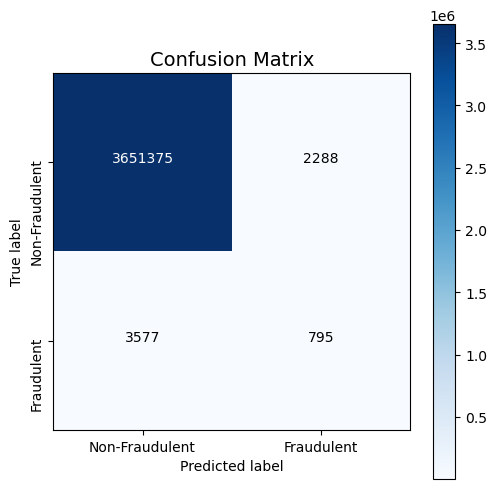

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3653663
           1       0.26      0.18      0.21      4372

    accuracy                           1.00   3658035
   macro avg       0.63      0.59      0.61   3658035
weighted avg       1.00      1.00      1.00   3658035

Optimal Threshold: 0.008374384236453989
ROC for test dataset 79.628%


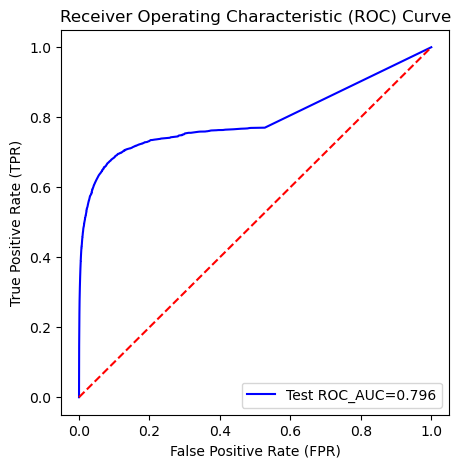


Time required to train the model: 142 minutes
****************************************************************************************************


In [24]:
## Decision Tree Model [Class Weighted]
results_df, clf_dt_weigh_data = DecisionTree_StratifiedKFoldCV_Model(None, X_train, y_train, X_val, y_val, 
                         "Weighted Dataset", "Decision Tree with StratifiedKFoldCV", results_df)

### Decision Tree (undersampling)

### Decision Tree (oversampling)

In [25]:
sm = over_sampling.SMOTE(random_state=0)                                    # Creating a class instance of SMOTE()   
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

****************************************************************************************************
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Data Handling Technique: {data_handling_technique}
Model Name: {model_name}


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 DecisionTreeClassifier(class_weight={0: 0.5, 1: 0.5}, max_depth=9,
                       min_samples_leaf=5, random_state=0)
Best ROC_AUC (mean cross-validated score): 0.015005541833523059
Best (Optimal) Parameters: {'decisiontreeclassifier__min_samples_leaf': 5, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__max_depth': 9, 'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__class_weight': {1: 0.5, 0: 0.5}}

Optimal hyperparameters:
Best min_samples_leaf: 5
Best class_weight: {1: 0.5, 0: 0.5}
Best max_depth: 9
Best max_features: None
Best criterion: gini

Prediction and Evaluation results: On Actual TEST SET

Test ROC_AUC:

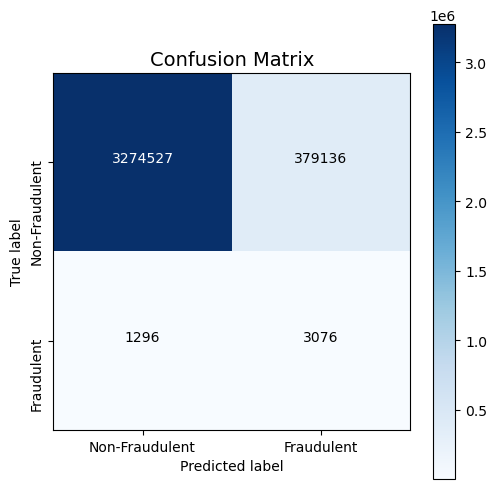

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95   3653663
           1       0.01      0.70      0.02      4372

    accuracy                           0.90   3658035
   macro avg       0.50      0.80      0.48   3658035
weighted avg       1.00      0.90      0.94   3658035

Optimal Threshold: 0.32608695652173914
ROC for test dataset 87.961%


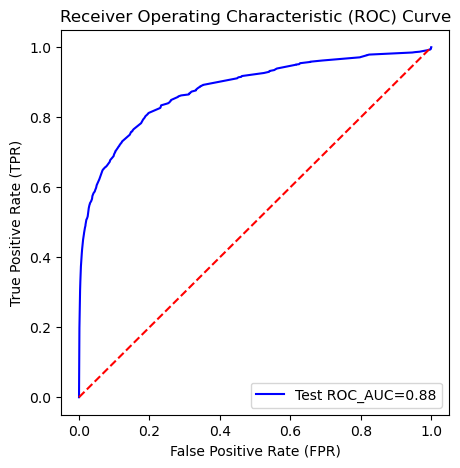


Time required to train the model: 352 minutes
****************************************************************************************************


In [26]:
## Decision Tree Model (SMOTE) - BALANCED DATASET         

# Building Model and Evaluating Results
results_df, clf_dt_smote_bal_data = DecisionTree_StratifiedKFoldCV_Model(sm, X_train, y_train, X_val, y_val,  
             "SMOTE - Balanced Dataset", "Decision Tree with StratifiedKFoldCV", results_df)

In [27]:
results_df

,Data Handling Technique,Model,ROC_AUC_cv,ROC_AUC_test,Threshold,Precision,Recall,F1 score,Our Score
0,Weighted Dataset,Decision Tree with StratifiedKFoldCV,0.205129,0.796275,0.008374,0.257866,0.181839,0.213280,-193742.06
0,SMOTE - Balanced Dataset,Decision Tree with StratifiedKFoldCV,0.015006,0.879607,0.326087,0.008048,0.703568,0.015914,-5643441.08


### Decision Tree (mix)

### Balanced Random Forest